In [15]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from datetime import datetime
import numpy as np

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [16]:
base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [17]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [18]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [19]:
# Number of columns
len(df.columns)

300

In [20]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [21]:
# Count rows
df.count()

50401

In [22]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [23]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [24]:
# Show 20 columns with least nulls
nulls_pd.tail(20)

,null_count
BE_load_actual_entsoe_transparency,1
DE_amprion_load_forecast_entsoe_transparency,1
DE_tennet_wind_onshore_generation_actual,1
DE_amprion_load_actual_entsoe_transparency,1
DE_50hertz_load_forecast_entsoe_transparency,1
DE_50hertz_wind_generation_actual,1
DE_50hertz_wind_offshore_generation_actual,1
DE_50hertz_load_actual_entsoe_transparency,1
DE_50hertz_wind_onshore_generation_actual,1
DE_amprion_wind_onshore_generation_actual,1


### Preprocessing

In [25]:
# Drop duplicates
df_no_duplicates = df.dropDuplicates()
df_no_duplicates.count()

50401

In [26]:
from pyspark.sql.functions import col, percentile_approx
from pyspark.sql.types import NumericType

# Function to compute median for a column (using percentile_approx)
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Get numeric columns in the DataFrame
numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, NumericType)]

# Compute median values for all numeric columns in parallel
median_values = {}
for c in numeric_columns:
    try:
        median_val = get_median(df, c)
        median_values[c] = median_val
    except Exception as e:
        print(f"Skipping column {c}: {e}")

# Apply the fillna operation for all numeric columns with their respective medians
df_filled = df
for c, median_val in median_values.items():
    df_filled = df_filled.fillna({c: median_val})

df_filled.show(5)  # Show the first 5 rows of the filled DataFrame


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [27]:
#Print all DE columns
de_columns = [col for col in df_filled.columns if col.startswith("DE_")]
print(de_columns)

['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_LU_load_actual_entsoe_transparency', 'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead', 'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual', 'DE_LU_wind_offshore_generation_actual', 'DE_LU_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_t

In [28]:
# Parse timestamp
df_filled = df_filled.withColumn("timestamp", to_timestamp("utc_timestamp"))
df_filled = df_filled.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

In [29]:
# Check how the columns split
for col in df.columns:
    print(f"Column: {col}, Split: {col.split('_')}")


Column: utc_timestamp, Split: ['utc', 'timestamp']
Column: cet_cest_timestamp, Split: ['cet', 'cest', 'timestamp']
Column: AT_load_actual_entsoe_transparency, Split: ['AT', 'load', 'actual', 'entsoe', 'transparency']
Column: AT_load_forecast_entsoe_transparency, Split: ['AT', 'load', 'forecast', 'entsoe', 'transparency']
Column: AT_price_day_ahead, Split: ['AT', 'price', 'day', 'ahead']
Column: AT_solar_generation_actual, Split: ['AT', 'solar', 'generation', 'actual']
Column: AT_wind_onshore_generation_actual, Split: ['AT', 'wind', 'onshore', 'generation', 'actual']
Column: BE_load_actual_entsoe_transparency, Split: ['BE', 'load', 'actual', 'entsoe', 'transparency']
Column: BE_load_forecast_entsoe_transparency, Split: ['BE', 'load', 'forecast', 'entsoe', 'transparency']
Column: BE_solar_generation_actual, Split: ['BE', 'solar', 'generation', 'actual']
Column: BE_wind_generation_actual, Split: ['BE', 'wind', 'generation', 'actual']
Column: BE_wind_offshore_generation_actual, Split: ['BE

In [31]:
# Get a list of country codes from the column names
country_codes = set(
    col.split('_')[0] for col in df.columns if len(col.split('_')) > 1 and len(col.split('_')[0]) == 2 and col.split('_')[0].isalpha()
)

print(country_codes)


{'PL', 'SK', 'FR', 'GR', 'PT', 'RS', 'BE', 'SE', 'HU', 'ES', 'UA', 'GB', 'ME', 'BG', 'EE', 'NL', 'CZ', 'IE', 'DE', 'DK', 'NO', 'CH', 'RO', 'LV', 'FI', 'LU', 'CY', 'AT', 'SI', 'HR', 'LT', 'IT'}


In [36]:
# Let's start with german data only (DE)
de_cols = [col for col in df_filled.columns if col.startswith("DE_")]
selected_columns = ["timestamp"] + de_cols
de_df = df_filled.select(*selected_columns)

In [32]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

In [39]:
# Define the fields for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

# Define the renaming template for each country (example with 'DE')
rename_template = {
    "load_actual_entsoe_transparency": "consumption",
    "price_day_ahead": "price_day_ahead",
    "load_forecast_entsoe_transparency": "consumption_forecast",
    "solar_capacity": "solar_capacity",
    "solar_generation_actual": "solar_generation",
    "solar_profile": "solar_profile",
    "wind_capacity": "wind_capacity",
    "wind_generation_actual": "wind_generation",
    "wind_profile": "wind_profile",
    "wind_offshore_capacity": "wind_offshore_capacity",
    "wind_offshore_generation_actual": "wind_offshore_generation",
    "wind_offshore_profile": "wind_offshore_profile",
    "wind_onshore_capacity": "wind_onshore_capacity",
    "wind_onshore_generation_actual": "wind_onshore_generation",
    "wind_onshore_profile": "wind_onshore_profile"
}

def row_to_dict(row, country):
    row_dict = row.asDict()

    # Generate dictionaries for generation, capacity, and profile
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }

    # Return the structured dictionary to insert into MongoDB
    return {
        "timestamp": row_dict.get("timestamp", None),
        "country": country,  # Dynamic country
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile
    }

# Only process country code 'DE' for testing
country = 'DE'

# Filter columns that start with the country code 'DE'
country_columns = [col for col in df_filled.columns if col.startswith(f"{country}_")]
print(country_columns)

# Create a dynamic renaming map for the country
rename_map = {f"{country}_{key}": f"{value}" for key, value in rename_template.items()}
print(rename_map)

# Filter the rename map to only include columns in the country-specific DataFrame
rename_map = {old: new for old, new in rename_map.items() if old in country_columns}
print(rename_map)

# Select columns for the current country and rename them based on the rename map
country_df = df_filled.select(*country_columns)
for old_col, new_col in rename_map.items():
    country_df = country_df.withColumnRenamed(old_col, new_col)
    print(f"Renamed {old_col} to {new_col}")
    
# Debugging: Show the DataFrame schema and the first few rows after renaming
country_df.printSchema()
country_df.show(5)

# Convert to an RDD and apply the row_to_dict function to structure the data
rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

# Collect the data to insert into MongoDB
data_to_insert = rdd_docs.collect()

# Insert into MongoDB if there is data for this country
if data_to_insert:
    collection.insert_many(data_to_insert)
    print(f"Data for {country} inserted successfully.")
else:
    print(f"No data found for {country}.")


['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_LU_load_actual_entsoe_transparency', 'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead', 'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual', 'DE_LU_wind_offshore_generation_actual', 'DE_LU_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_t

In [ ]:
# Loop through each country code
for country in country_codes:
    # Filter columns that start with the country code
    country_columns = [col for col in df.columns if col.startswith(f"{country}_")]

    # Create a dynamic renaming map for the country
    rename_map = {f"{country}_{key}": f"{country}_{value}" for key, value in rename_template.items()}

    # Filter the rename map to only include columns in the country-specific DataFrame
    rename_map = {old: new for old, new in rename_map.items() if old in country_columns}

    # Select columns for the current country and rename them based on the rename map
    country_df = df.select(*country_columns)
    for old_col, new_col in rename_map.items():
        country_df = country_df.withColumnRenamed(old_col, new_col)

    # Convert to an RDD and apply the row_to_dict function to structure the data
    rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

    # Collect the data to insert into MongoDB
    data_to_insert = rdd_docs.collect()

    # Insert into MongoDB if there is data for this country
    if data_to_insert:
        collection.insert_many(data_to_insert)
        print(f"Data for {country} inserted successfully.")
    else:
        print(f"No data found for {country}.")

### Data to MongoDB

In [37]:
# Rename columns for easier access
rename_map = {
    "DE_load_actual_entsoe_transparency": "consumption",
    "DE_LU_price_day_ahead": "price_day_ahead",
    "DE_load_forecast_entsoe_transparency": "consumption_forecast",
    "DE_solar_capacity": "solar_capacity",
    "DE_solar_generation_actual": "solar_generation",
    "DE_solar_profile": "solar_profile",
    "DE_wind_capacity": "wind_capacity",
    "DE_wind_generation_actual": "wind_generation",
    "DE_wind_profile": "wind_profile",
    "DE_wind_offshore_capacity": "wind_offshore_capacity",
    "DE_wind_offshore_generation_actual": "wind_offshore_generation",
    "DE_wind_offshore_profile": "wind_offshore_profile",
    "DE_wind_onshore_capacity": "wind_onshore_capacity",
    "DE_wind_onshore_generation_actual": "wind_onshore_generation",
    "DE_wind_onshore_profile": "wind_onshore_profile",
    "DE_50hertz_load_actual_entsoe_transparency": "consumption_50hertz",
    "DE_50hertz_wind_onshore_generation_actual": "wind_onshore_50hertz",
    "DE_LU_load_actual_entsoe_transparency": "consumption_LU",
    "DE_LU_load_forecast_entsoe_transparency": "consumption_forecast_LU",
    "DE_LU_solar_generation_actual": "solar_generation_LU",
    "DE_LU_wind_generation_actual": "wind_generation_LU",
    "DE_LU_wind_offshore_generation_actual": "wind_offshore_LU",
    "DE_LU_wind_onshore_generation_actual": "wind_onshore_LU",
    "DE_amprion_load_actual_entsoe_transparency": "consumption_amprion",
    "DE_amprion_load_forecast_entsoe_transparency": "consumption_forecast_amprion",
    "DE_amprion_solar_generation_actual": "solar_amprion",
    "DE_amprion_wind_generation_actual": "wind_amprion",
    "DE_tennet_load_actual_entsoe_transparency": "consumption_tennet",
    "DE_tennet_load_forecast_entsoe_transparency": "consumption_forecast_tennet",
    "DE_tennet_solar_generation_actual": "solar_tennet",
    "DE_tennet_wind_generation_actual": "wind_tennet",
    "DE_tennet_wind_offshore_generation_actual": "wind_offshore_tennet",
    "DE_tennet_wind_onshore_generation_actual": "wind_onshore_tennet",
    "DE_transnetbw_load_actual_entsoe_transparency": "consumption_transnetbw",
    "DE_transnetbw_load_forecast_entsoe_transparency": "consumption_forecast_transnetbw",
    "DE_transnetbw_solar_generation_actual": "solar_transnetbw",
    "DE_transnetbw_wind_onshore_generation_actual": "wind_onshore_transnetbw"
}

for old_col, new_col in rename_map.items():
    de_df = de_df.withColumnRenamed(old_col, new_col)

In [38]:
# Convert rows to dictionarys for MongoDB
# Define the fields to extract for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]  # extend this list
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

def row_to_dict(row):
    row_dict = row.asDict()
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }
    return {
        "timestamp": row_dict["timestamp"],
        "country": "DE",
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile       
    }

rdd_docs = de_df.rdd.map(row_to_dict)

In [39]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

# Collect to driver (safe if you filtered data down enough)
documents = rdd_docs.collect()

# Insert in bulk
collection.insert_many(documents)

InsertManyResult([ObjectId('67f6b29077af73f185519349'), ObjectId('67f6b29077af73f18551934a'), ObjectId('67f6b29077af73f18551934b'), ObjectId('67f6b29077af73f18551934c'), ObjectId('67f6b29077af73f18551934d'), ObjectId('67f6b29077af73f18551934e'), ObjectId('67f6b29077af73f18551934f'), ObjectId('67f6b29077af73f185519350'), ObjectId('67f6b29077af73f185519351'), ObjectId('67f6b29077af73f185519352'), ObjectId('67f6b29077af73f185519353'), ObjectId('67f6b29077af73f185519354'), ObjectId('67f6b29077af73f185519355'), ObjectId('67f6b29077af73f185519356'), ObjectId('67f6b29077af73f185519357'), ObjectId('67f6b29077af73f185519358'), ObjectId('67f6b29077af73f185519359'), ObjectId('67f6b29077af73f18551935a'), ObjectId('67f6b29077af73f18551935b'), ObjectId('67f6b29077af73f18551935c'), ObjectId('67f6b29077af73f18551935d'), ObjectId('67f6b29077af73f18551935e'), ObjectId('67f6b29077af73f18551935f'), ObjectId('67f6b29077af73f185519360'), ObjectId('67f6b29077af73f185519361'), ObjectId('67f6b29077af73f1855193

### Data from MongoDB

In [ ]:
# Read from MongoDB
df_read = spark.read.format("mongo").load()

# Extract the 'timestamp' and 'wind_generation' columns, and convert 'timestamp' to a date
df_filtered = df_read.select(
    "timestamp",
    "generation.wind_generation"
).withColumn("date", to_date(col("timestamp")))

# Calculate daily average of wind generation
daily_avg_df = df_filtered.groupBy("date").agg(
    avg("wind_generation").alias("avg_wind_generation")
)
# Sort by date
daily_avg_df = daily_avg_df.orderBy("date")

# Show the daily averages
daily_avg_df.show(20)

+----------+-------------------+
|      date|avg_wind_generation|
+----------+-------------------+
|2015-01-01| 11811.238095238095|
|2015-01-02|          24670.125|
|2015-01-03| 20597.541666666668|
|2015-01-04|           16706.25|
|2015-01-05|          10783.125|
|2015-01-06|           3653.875|
|2015-01-07|  8599.458333333334|
|2015-01-08|          16999.875|
|2015-01-09|           26895.75|
|2015-01-10| 25876.666666666668|
|2015-01-11| 26227.666666666668|
|2015-01-12| 26347.916666666668|
|2015-01-13| 22571.583333333332|
|2015-01-14| 17446.333333333332|
|2015-01-15| 21736.083333333332|
|2015-01-16| 13659.208333333334|
|2015-01-17|  5160.416666666667|
|2015-01-18|  5950.416666666667|
|2015-01-19|           1672.875|
|2015-01-20|  791.5833333333334|
+----------+-------------------+
only showing top 20 rows



In [ ]:
# Create a list of columns to average (skip timestamps and 'date')
cols_to_avg = [c for c in df.columns if c not in ["utc_timestamp", "cet_cest_timestamp", "date"]]

# Group and aggregate
daily_avg_df = df.groupBy("date").agg(
    *[avg(c).alias(f"{c}_daily_avg") for c in cols_to_avg]
)


In [ ]:
# Again too wide to show properly
# The data itself should be fine though
daily_avg_df.show(10)

+----------+--------------------------------------------+----------------------------------------------+----------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-----------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+---------------------------+------------------------------------+----------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+-------------------------------

In [ ]:
daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").show(10)

+----------+--------------------------------+-----------------------------------------------+
|      date|ie_sem_price_day_ahead_daily_avg|ie_sem_wind_onshore_generation_actual_daily_avg|
+----------+--------------------------------+-----------------------------------------------+
|2015-03-09|               43.07000000000002|                                        1621.25|
|2015-05-19|               43.07000000000002|                             1639.0416666666667|
|2015-03-06|               43.07000000000002|                             1947.0416666666667|
|2015-04-09|               43.07000000000002|                              331.0833333333333|
|2015-05-10|               43.07000000000002|                             1720.2083333333333|
|2015-03-12|               43.07000000000002|                                        1373.75|
|2015-03-16|               43.07000000000002|                                          287.0|
|2015-04-01|               43.07000000000002|               

In [ ]:
# PDF = Pandas Data Frame
# Change/add to these as needed

pdf = daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").orderBy("date").toPandas()

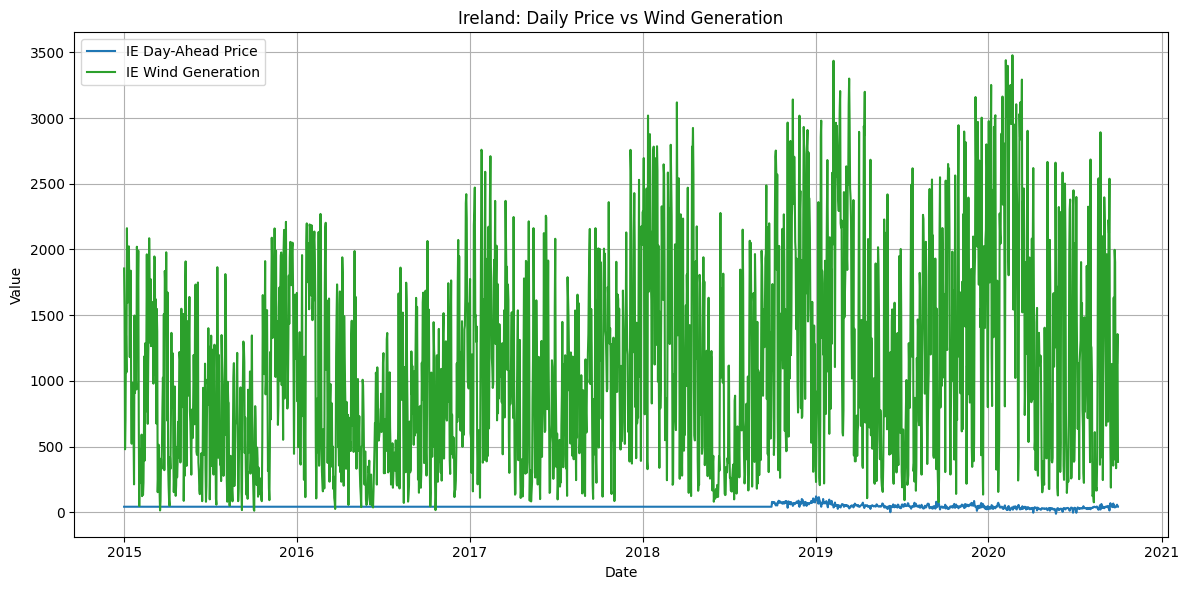

In [ ]:
# An example plot
plt.figure(figsize=(12, 6))

# Play around with these and figure out some meaningful comparisons
# First axis
plt.plot(pdf["date"], pdf["ie_sem_price_day_ahead_daily_avg"], label="IE Day-Ahead Price", color="tab:blue")

# Second axis
plt.plot(pdf["date"], pdf["ie_sem_wind_onshore_generation_actual_daily_avg"], label="IE Wind Generation", color="tab:green")

plt.title("Ireland: Daily Price vs Wind Generation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()